In [7]:
pip install --user seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas


  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def process_data(filename):
    # Load the dataset dynamically based on the filename
    data = pd.read_csv(f'dataset/{filename}')

    # Ensure the 'Price' column is treated as string and replace wrong currency symbols
    data['Price'] = data['Price'].astype(str).str.replace(r'[^\d]', '', regex=True).astype(float)

    # Data Analysis
    print(f'--- Data Analysis for {filename} ---')
    print(data.describe())

    # Distribution of Prices
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Price'], kde=True, bins=30)
    plt.title(f'Distribution of Prices in {filename}')
    plt.xlabel('Price (₦)')
    plt.ylabel('Frequency')
    plt.show()

    # Average Price by Number of Bedrooms
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Bedrooms', y='Price', data=data)
    plt.title(f'Average Price by Number of Bedrooms in {filename}')
    plt.xlabel('Number of Bedrooms')
    plt.ylabel('Average Price (₦)')
    plt.show()

    # Count of Properties by Neighborhood
    plt.figure(figsize=(12, 6))
    sns.countplot(y='Neighborhood', data=data, order=data['Neighborhood'].value_counts().index)
    plt.title(f'Count of Properties by Neighborhood in {filename}')
    plt.xlabel('Count')
    plt.ylabel('Neighborhood')
    plt.show()

    # Price Distribution by Neighborhood
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Neighborhood', y='Price', data=data)
    plt.title(f'Price Distribution by Neighborhood in {filename}')
    plt.xlabel('Neighborhood')
    plt.ylabel('Price (₦)')
    plt.xticks(rotation=90)
    plt.show()

    # Save Cleaned Data (Optional)
    cleaned_filename = f'cleaned_{filename}'
    data.to_csv(f'/content/drive/MyDrive/LagosHousePricing/{cleaned_filename}', index=False)
    print(f'Saved cleaned data to {cleaned_filename}')

# List of filenames
filenames = ['ikeja.csv', 'lekki.csv', 'vi.csv', 'lagos.csv', 'eda.csv', 'ikoyi.csv']  # Add all your filenames here

# Process each dataset
for filename in filenames:
    process_data(filename)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
!pip install dask dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from dask_ml.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def load_and_clean_data(filename):
    # Load the cleaned dataset
    data = dd.read_csv(f'/content/drive/MyDrive/LagosHousePricing/{filename}')

    # Convert 'Price' to numeric, coerce errors to NaN
    if data['Price'].dtype == 'object':
        # Remove non-numeric characters and coerce to float, errors='coerce' to handle NaNs
        data['Price'] = data['Price'].str.replace(r'[^\d.]', '', regex=True)
        data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

    # Drop rows with NaN values in critical columns
    critical_columns = ['Price']  # Adjust as per your dataset
    data = data.dropna(subset=critical_columns)

    return data

def process_and_train_model(filenames):
    # Load and clean each dataset
    cleaned_dataframes = [load_and_clean_data(filename) for filename in filenames]

    # Combine all cleaned datasets
    combined_data = dd.concat(cleaned_dataframes, axis=0, ignore_unknown_divisions=True)

    # Compute to get the DataFrame in memory
    combined_data = combined_data.compute()

    # Check the combined data
    print(f"Combined Data Shape: {combined_data.shape}")
    print(f"Combined Data Columns: {combined_data.columns}")
    print(f"Combined Data Sample: {combined_data.head()}")

    # Ensure the data is shuffled
    combined_data = combined_data.sample(frac=1, random_state=42)

    # Identify categorical features if any
    categorical_features = combined_data.select_dtypes(include=['object']).columns.tolist()

    # One-hot encode categorical features
    if categorical_features:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(combined_data[categorical_features])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

        # Drop original categorical columns and concatenate the encoded columns
        combined_data = combined_data.drop(columns=categorical_features)
        combined_data = pd.concat([combined_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

    # Ensure all columns are numeric
    combined_data = combined_data.apply(pd.to_numeric, errors='coerce')

    # Drop any remaining NaN values
    combined_data = combined_data.dropna()

    # Check the cleaned data
    print(f"Cleaned Data Shape: {combined_data.shape}")
    print(f"Cleaned Data Sample: {combined_data.head()}")

    if combined_data.empty:
        print("No data available after cleaning. Please check the input data.")
        return

    # Define features (X) and target (y)
    X = combined_data.drop('Price', axis=1)
    y = combined_data['Price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2 Score: {r2}')

# List of cleaned filenames
cleaned_filenames = [
    'cleaned_ikeja.csv',
    'cleaned_lekki.csv',
    'cleaned_vi.csv',
    'cleaned_lagos.csv',
    'cleaned_eda.csv',
    'cleaned_ikoyi.csv'
]

# Process and train the model
process_and_train_model(cleaned_filenames)


Combined Data Shape: (145939, 14)
Combined Data Columns: Index(['Unnamed: 0', 'Title', 'Location', 'Currency', 'Price', 'Serviced',
       'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets',
       'Neighborhood', 'Type', 'City'],
      dtype='object')
Combined Data Sample:    Unnamed: 0                                        Title  \
0         0.0                                        Shops   
1         1.0      Newly Built 5 Bedrooms Detached Triplex   
2         2.0                                  1800m2 Land   
3         3.0              5 Bedroom Fully Detached Duplex   
4         4.0  Luxury Built 4bedroom Fully Detached Duplex   

                                            Location Currency        Price  \
0   Allen Avenue Roundabout Allen Avenue Ikeja Lagos        ₦     750000.0   
1  Eso Close, Off Oduduwa Crescent, Gra Ikeja, La...        ₦  280000000.0   
2         Off Adedayo Banjo Street Opebi Ikeja Lagos        ₦  220000000.0   
3                           

              Price      Serviced   Newly Built     Furnished      Bedrooms  \
count  5.710800e+04  57108.000000  57108.000000  57108.000000  53030.000000   
mean   6.016344e+09      0.121822      0.377355      0.081302      3.369112   
std    8.296600e+11      0.327083      0.484729      0.273301      1.959340   
min    0.000000e+00      0.000000      0.000000      0.000000      0.000000   
25%    6.000000e+07      0.000000      0.000000      0.000000      2.000000   
50%    9.200000e+07      0.000000      0.000000      0.000000      4.000000   
75%    1.700000e+08      0.000000      1.000000      0.000000      5.000000   
max    1.400000e+14      1.000000      1.000000      1.000000     18.000000   

          Bathrooms       Toilets  
count  51736.000000  51556.000000  
mean       3.160700      3.603674  
std        2.229059      2.503753  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        4.000000      5.000000  
75%        5.000000      5.000000  


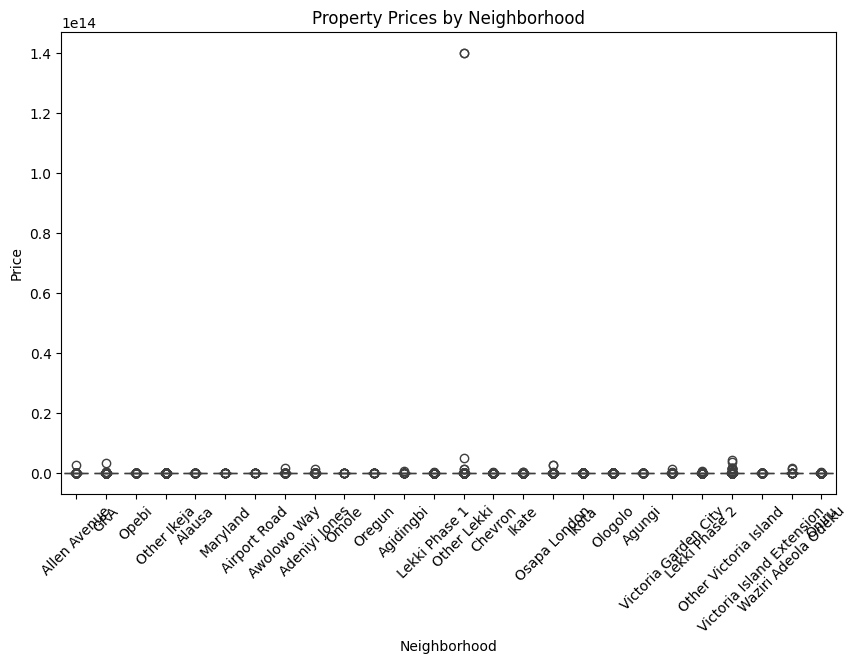

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
ikeja_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_ikeja.csv')
lekki_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_lekki.csv')
vi_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_vi.csv')
lagos_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_lagos.csv')
eda_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_eda.csv')

# Drop the 'Unnamed: 0' column if it exists
ikeja_df = ikeja_df.drop(columns=['Unnamed: 0'])
lekki_df = lekki_df.drop(columns=['Unnamed: 0'])
vi_df = vi_df.drop(columns=['Unnamed: 0'])

# Standardize column names
standard_columns = ['Title', 'Location', 'Currency', 'Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets', 'Neighborhood']
ikeja_df.columns = standard_columns
lekki_df.columns = standard_columns
vi_df.columns = standard_columns

# Combine datasets
combined_df = pd.concat([ikeja_df, lekki_df, vi_df])

# Replace non-numeric values with NaN
combined_df['Bedrooms'] = combined_df['Bedrooms'].replace(' beds', '', regex=True).replace('', np.nan)
combined_df['Bathrooms'] = combined_df['Bathrooms'].replace(' baths', '', regex=True).replace('', np.nan)
combined_df['Toilets'] = combined_df['Toilets'].replace(' Toilets', '', regex=True).replace('', np.nan)

# Convert data types
combined_df['Price'] = combined_df['Price'].astype(float)
combined_df['Bedrooms'] = combined_df['Bedrooms'].astype(float)
combined_df['Bathrooms'] = combined_df['Bathrooms'].astype(float)
combined_df['Toilets'] = combined_df['Toilets'].astype(float)

# Descriptive statistics
print(combined_df.describe())

# Initial visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Neighborhood', y='Price', data=combined_df)
plt.title('Property Prices by Neighborhood')
plt.xticks(rotation=45)
plt.show()

              Price      Serviced   Newly Built     Furnished      Bedrooms  \
count  5.710800e+04  57108.000000  57108.000000  57108.000000  53030.000000   
mean   6.016344e+09      0.121822      0.377355      0.081302      3.369112   
std    8.296600e+11      0.327083      0.484729      0.273301      1.959340   
min    0.000000e+00      0.000000      0.000000      0.000000      0.000000   
25%    6.000000e+07      0.000000      0.000000      0.000000      2.000000   
50%    9.200000e+07      0.000000      0.000000      0.000000      4.000000   
75%    1.700000e+08      0.000000      1.000000      0.000000      5.000000   
max    1.400000e+14      1.000000      1.000000      1.000000     18.000000   

          Bathrooms       Toilets  
count  51736.000000  51556.000000  
mean       3.160700      3.603674  
std        2.229059      2.503753  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        4.000000      5.000000  
75%        5.000000      5.000000  


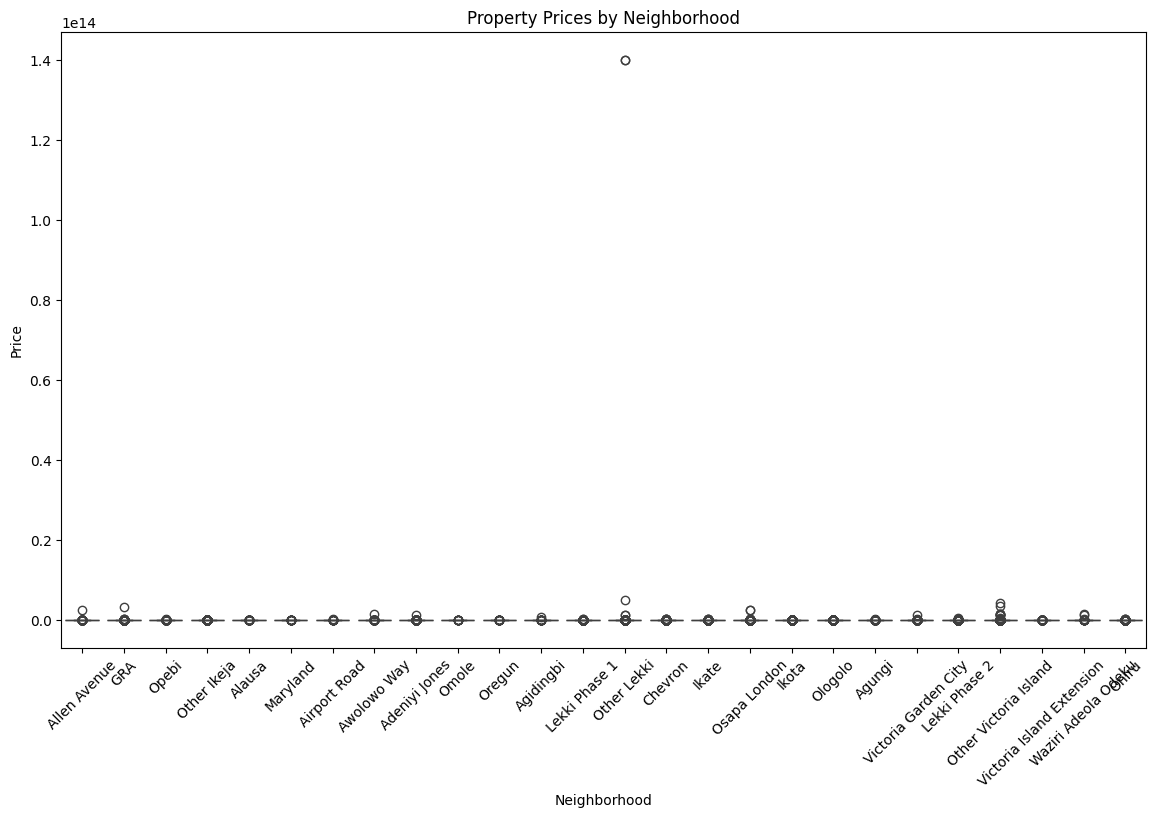

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
ikeja_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_ikeja.csv')
lekki_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_lekki.csv')
vi_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_vi.csv')
lagos_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_lagos.csv')
eda_df = pd.read_csv('/content/drive/MyDrive/LagosHousePricing/cleaned_eda.csv')

# Drop the 'Unnamed: 0' column if it exists
ikeja_df = ikeja_df.drop(columns=['Unnamed: 0'])
lekki_df = lekki_df.drop(columns=['Unnamed: 0'])
vi_df = vi_df.drop(columns=['Unnamed: 0'])

# Standardize column names
standard_columns = ['Title', 'Location', 'Currency', 'Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets', 'Neighborhood']
ikeja_df.columns = standard_columns
lekki_df.columns = standard_columns
vi_df.columns = standard_columns

# Combine datasets
combined_df = pd.concat([ikeja_df, lekki_df, vi_df])

# Replace non-numeric values with NaN
combined_df['Bedrooms'] = combined_df['Bedrooms'].replace(' beds', '', regex=True).replace('', np.nan)
combined_df['Bathrooms'] = combined_df['Bathrooms'].replace(' baths', '', regex=True).replace('', np.nan)
combined_df['Toilets'] = combined_df['Toilets'].replace(' Toilets', '', regex=True).replace('', np.nan)

# Convert data types
combined_df['Price'] = combined_df['Price'].astype(float)
combined_df['Bedrooms'] = combined_df['Bedrooms'].astype(float)
combined_df['Bathrooms'] = combined_df['Bathrooms'].astype(float)
combined_df['Toilets'] = combined_df['Toilets'].astype(float)

# Descriptive statistics
print(combined_df.describe())

# Initial visualization
plt.figure(figsize=(14, 8))
sns.boxplot(x='Neighborhood', y='Price', data=combined_df)
plt.title('Property Prices by Neighborhood')
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
ikeja_df = pd.read_csv('cleaned_ikeja.csv')
lekki_df = pd.read_csv('cleaned_lekki.csv')
vi_df = pd.read_csv('cleaned_vi.csv')

# Drop the 'Unnamed: 0' column if it exists
ikeja_df = ikeja_df.drop(columns=['Unnamed: 0'], errors='ignore')
lekki_df = lekki_df.drop(columns=['Unnamed: 0'], errors='ignore')
vi_df = vi_df.drop(columns=['Unnamed: 0'], errors='ignore')

# Standardize column names
standard_columns = ['Title', 'Location', 'Currency', 'Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets', 'Neighborhood']
ikeja_df.columns = standard_columns
lekki_df.columns = standard_columns
vi_df.columns = standard_columns

# Combine datasets
combined_df = pd.concat([ikeja_df, lekki_df, vi_df])

# Replace non-numeric values with NaN
combined_df['Bedrooms'] = combined_df['Bedrooms'].replace(' beds', '', regex=True).replace('', np.nan)
combined_df['Bathrooms'] = combined_df['Bathrooms'].replace(' baths', '', regex=True).replace('', np.nan)
combined_df['Toilets'] = combined_df['Toilets'].replace(' Toilets', '', regex=True).replace('', np.nan)

# Convert data types
combined_df['Price'] = combined_df['Price'].astype(float)
combined_df['Bedrooms'] = combined_df['Bedrooms'].astype(float)
combined_df['Bathrooms'] = combined_df['Bathrooms'].astype(float)
combined_df['Toilets'] = combined_df['Toilets'].astype(float)

# Identify non-numeric columns
non_numeric_columns = combined_df.select_dtypes(include=['object']).columns

# Convert categorical columns to dummy variables
combined_df = pd.get_dummies(combined_df, columns=non_numeric_columns, drop_first=True)

# Handle missing values by filling with median
combined_df.fillna(combined_df.median(), inplace=True)

# Check the final column names after dummy variable creation
print(combined_df.columns)

# Adjust relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets']

# Add 'Neighborhood' dummy variable columns if they exist
for col in combined_df.columns:
    if col.startswith('Neighborhood_'):
        relevant_columns.append(col)

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df[relevant_columns]

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Function to predict house price based on user input
def predict_house_price(title, location, currency, serviced, newly_built, furnished, bedrooms, bathrooms, toilets, neighborhood):
    input_data = {
        'Serviced': serviced,
        'Newly Built': newly_built,
        'Furnished': furnished,
        'Bedrooms': bedrooms,
        'Bathrooms': bathrooms,
        'Toilets': toilets,
    }

    # Add dummy variables for categorical columns
    for col in X.columns:
        if col.startswith('Neighborhood_'):
            input_data[col] = 1 if f'Neighborhood_{neighborhood}' == col else 0

    input_df = pd.DataFrame([input_data])

    predicted_price = model.predict(input_df)[0]
    return predicted_price

# Example usage of the predict_house_price function
predicted_price = predict_house_price(
    title='Luxury Apartment',
    location='Ikeja',
    currency='NGN',
    serviced=0,
    newly_built=1,
    furnished=1,
    bedrooms=3,
    bathrooms=2,
    toilets=2,
    neighborhood='GRA Ikeja'
)

print(f'Predicted House Price: {predicted_price}')

Index(['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms',
       'Bathrooms', 'Toilets',
       'Title_ 6 Bedrooms Detached Duplex Converted To Office Space',
       'Title_ 7 Bedrooms Including 2 Master Bedrooms Underground Car Park Swimming Pool',
       'Title_ New 4 Bedroom Terrace',
       ...
       'Neighborhood_Oniru', 'Neighborhood_Opebi', 'Neighborhood_Oregun',
       'Neighborhood_Osapa London', 'Neighborhood_Other Ikeja',
       'Neighborhood_Other Lekki', 'Neighborhood_Other Victoria Island',
       'Neighborhood_Victoria Garden City',
       'Neighborhood_Victoria Island Extension',
       'Neighborhood_Waziri Adeola Odeku'],
      dtype='object', length=43735)
Mean Squared Error: 1.718958301582681e+24
R^2 Score: -0.00010343002688983916
Predicted House Price: 62034265.51226551


In [2]:
pip install scikit-learn --upgrade

  Using cached https://files.pythonhosted.org/packages/9d/20/0ffe8665a44bce7616bd33d4368a198fecad3b226bcafa38c63ef0f6286f/scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-0.21.3.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.



In [ ]:
pip uninstall scikit-learn

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Example data setup (replace with your actual data loading and cleaning steps)
data = {
    'Bedrooms': [3, 4, None, 2, 3],
    'Bathrooms': [2, None, 3, 1, 2],
    'Toilets': [2, 3, None, 1, 2],
    'Location': ['Ikeja', 'Lekki', 'Victoria Island', 'Ikeja', 'Lekki'],
    'Currency': ['NGN', 'USD', 'EUR', 'NGN', 'USD'],
    'Neighborhood': ['GRA Ikeja', 'Phase 1', 'Central', 'GRA Ikeja', 'Phase 1'],
    'Price': [250000, 400000, 600000, 300000, 350000],
    'Serviced': [1, 0, 1, 1, 0],
    'Newly Built': [1, 0, 0, 1, 0],
    'Furnished': [1, 0, 1, 0, 0]
}
combined_df = pd.DataFrame(data)

# Convert 'Bedrooms', 'Bathrooms', and 'Toilets' columns to numeric, coerce errors to NaN
combined_df['Bedrooms'] = pd.to_numeric(combined_df['Bedrooms'], errors='coerce')
combined_df['Bathrooms'] = pd.to_numeric(combined_df['Bathrooms'], errors='coerce')
combined_df['Toilets'] = pd.to_numeric(combined_df['Toilets'], errors='coerce')

# Use SimpleImputer to fill missing values with median
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Bedrooms', 'Bathrooms', 'Toilets']

# Transform only numeric columns and assign back to the original DataFrame
combined_df[numeric_cols] = imputer.fit_transform(combined_df[numeric_cols])

# Convert categorical columns to categorical dtype
cat_columns = ['Location', 'Currency', 'Neighborhood']
for col in cat_columns:
    combined_df[col] = combined_df[col].astype('category')

# Check existing categories and add 'Unknown' if not present
for col in cat_columns:
    if 'Unknown' not in combined_df[col].cat.categories:
        combined_df[col] = combined_df[col].cat.add_categories(['Unknown'])

# Fill missing values in categorical columns with 'Unknown'
combined_df[cat_columns] = combined_df[cat_columns].fillna('Unknown')

# Convert data types for numeric columns
combined_df['Price'] = combined_df['Price'].astype(float)
combined_df['Serviced'] = combined_df['Serviced'].astype(int)
combined_df['Newly Built'] = combined_df['Newly Built'].astype(int)
combined_df['Furnished'] = combined_df['Furnished'].astype(int)

# Convert categorical columns to dummy variables
combined_df = pd.get_dummies(combined_df, columns=cat_columns, drop_first=True)

# Check the final column names after dummy variable creation
print(combined_df.columns)

# Adjust relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets']

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df[relevant_columns]

# Check for NaN values in the reduced dataset
print(combined_df_reduced.isnull().sum())
print(combined_df_reduced.info())

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Function to predict house price based on user input
def predict_house_price(title, location, currency, serviced, newly_built, furnished, bedrooms, bathrooms, toilets, neighborhood):
    input_data = {
        'Serviced': [serviced],
        'Newly Built': [newly_built],
        'Furnished': [furnished],
        'Bedrooms': [bedrooms],
        'Bathrooms': [bathrooms],
        'Toilets': [toilets],
    }

    # Add dummy variables for categorical columns
    for col in X.columns:
        if col.startswith('Location_') and location in col:
            input_data[col] = [1]
        elif col.startswith('Currency_') and currency in col:
            input_data[col] = [1]
        elif col.startswith('Neighborhood_') and neighborhood in col:
            input_data[col] = [1]

    input_df = pd.DataFrame(input_data)

    # Predict using the model
    predicted_price = model.predict(input_df)[0]
    return predicted_price

# Example usage of the predict_house_price function
predicted_price = predict_house_price(
    title='Luxury Apartment',
    location='Ikeja',
    currency='NGN',
    serviced=0,
    newly_built=1,
    furnished=1,
    bedrooms=3,
    bathrooms=2,
    toilets=2,
    neighborhood='GRA Ikeja'
)

print(f'Predicted House Price: {predicted_price}')


Index(['Bedrooms', 'Bathrooms', 'Toilets', 'Price', 'Serviced', 'Newly Built',
       'Furnished', 'Location_Lekki', 'Location_Victoria Island',
       'Location_Unknown', 'Currency_NGN', 'Currency_USD', 'Currency_Unknown',
       'Neighborhood_GRA Ikeja', 'Neighborhood_Phase 1',
       'Neighborhood_Unknown'],
      dtype='object')
Price          0
Serviced       0
Newly Built    0
Furnished      0
Bedrooms       0
Bathrooms      0
Toilets        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
Price          5 non-null float64
Serviced       5 non-null int32
Newly Built    5 non-null int32
Furnished      5 non-null int32
Bedrooms       5 non-null float64
Bathrooms      5 non-null float64
Toilets        5 non-null float64
dtypes: float64(4), int32(3)
memory usage: 348.0 bytes
None
Mean Squared Error: 625000000.0
R^2 Score: nan
Predicted House Price: 324000.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib

# Example data setup (replace with your actual data loading and cleaning steps)
data = {
    'Bedrooms': [3, 4, None, 2, 3],
    'Bathrooms': [2, None, 3, 1, 2],
    'Toilets': [2, 3, None, 1, 2],
    'Location': ['Ikeja', 'Lekki', 'Victoria Island', 'Ikeja', 'Lekki'],
    'Currency': ['NGN', 'USD', 'EUR', 'NGN', 'USD'],
    'Neighborhood': ['GRA Ikeja', 'Phase 1', 'Central', 'GRA Ikeja', 'Phase 1'],
    'Price': [250000, 400000, 600000, 300000, 350000],
    'Serviced': [1, 0, 1, 1, 0],
    'Newly Built': [1, 0, 0, 1, 0],
    'Furnished': [1, 0, 1, 0, 0]
}
combined_df = pd.DataFrame(data)

# Convert 'Bedrooms', 'Bathrooms', and 'Toilets' columns to numeric, coerce errors to NaN
combined_df['Bedrooms'] = pd.to_numeric(combined_df['Bedrooms'], errors='coerce')
combined_df['Bathrooms'] = pd.to_numeric(combined_df['Bathrooms'], errors='coerce')
combined_df['Toilets'] = pd.to_numeric(combined_df['Toilets'], errors='coerce')

# Use SimpleImputer to fill missing values with median
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Bedrooms', 'Bathrooms', 'Toilets']

# Transform only numeric columns and assign back to the original DataFrame
combined_df[numeric_cols] = imputer.fit_transform(combined_df[numeric_cols])

# Convert categorical columns to categorical dtype
cat_columns = ['Location', 'Currency', 'Neighborhood']
for col in cat_columns:
    combined_df[col] = combined_df[col].astype('category')

# Check existing categories and add 'Unknown' if not present
for col in cat_columns:
    if 'Unknown' not in combined_df[col].cat.categories:
        combined_df[col] = combined_df[col].cat.add_categories(['Unknown'])

# Fill missing values in categorical columns with 'Unknown'
combined_df[cat_columns] = combined_df[cat_columns].fillna('Unknown')

# Convert data types for numeric columns
combined_df['Price'] = combined_df['Price'].astype(float)
combined_df['Serviced'] = combined_df['Serviced'].astype(int)
combined_df['Newly Built'] = combined_df['Newly Built'].astype(int)
combined_df['Furnished'] = combined_df['Furnished'].astype(int)

# Convert categorical columns to dummy variables
combined_df = pd.get_dummies(combined_df, columns=cat_columns, drop_first=True)

# Adjust relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets']

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df[relevant_columns]

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model as a pickle file
joblib.dump(model, 'model.pkl')


['model.pkl']

In [1]:
import sys
print(sys.version)

3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]


In [2]:
!pip install --upgrade scikit-learn==1.5.0

  Using cached scikit_learn-1.5.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.0.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.0-cp312-cp312-win_amd64.whl (10.9 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached numpy-2.0.0-cp312-cp312-win_amd64.whl (16.2 MB)
Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Example data setup (replace with your actual data loading and cleaning steps)
data = {
    'Bedrooms': [3, 4, None, 2, 3],
    'Bathrooms': [2, None, 3, 1, 2],
    'Toilets': [2, 3, None, 1, 2],
    'Location': ['Ikeja', 'Lekki', 'Victoria Island', 'Ikeja', 'Lekki'],
    'Currency': ['NGN', 'USD', 'EUR', 'NGN', 'USD'],
    'Neighborhood': ['GRA Ikeja', 'Phase 1', 'Central', 'GRA Ikeja', 'Phase 1'],
    'Price': [250000, 400000, 600000, 300000, 350000],
    'Serviced': [1, 0, 1, 1, 0],
    'Newly Built': [1, 0, 0, 1, 0],
    'Furnished': [1, 0, 1, 0, 0]
}
combined_df = pd.DataFrame(data)

# Convert 'Bedrooms', 'Bathrooms', and 'Toilets' columns to numeric, coerce errors to NaN
combined_df['Bedrooms'] = pd.to_numeric(combined_df['Bedrooms'], errors='coerce')
combined_df['Bathrooms'] = pd.to_numeric(combined_df['Bathrooms'], errors='coerce')
combined_df['Toilets'] = pd.to_numeric(combined_df['Toilets'], errors='coerce')

# Use SimpleImputer to fill missing values with median
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Bedrooms', 'Bathrooms', 'Toilets']

# Transform only numeric columns and assign back to the original DataFrame
combined_df[numeric_cols] = imputer.fit_transform(combined_df[numeric_cols])

# Convert categorical columns to categorical dtype
cat_columns = ['Location', 'Currency', 'Neighborhood']
combined_df[cat_columns] = combined_df[cat_columns].astype('category')

# Convert categorical columns to dummy variables
encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(combined_df[cat_columns])

# Get feature names from encoder categories
feature_names = encoder.get_feature_names_out(input_features=cat_columns)

# Create a DataFrame from encoded categorical columns
encoded_cols_df = pd.DataFrame(encoded_cols.toarray(), columns=feature_names)

# Combine encoded categorical columns with numeric columns
combined_df_processed = pd.concat([combined_df[numeric_cols], encoded_cols_df], axis=1)

# Add back the target variable 'Price' and other relevant columns
combined_df_processed['Serviced'] = combined_df['Serviced']
combined_df_processed['Newly Built'] = combined_df['Newly Built']
combined_df_processed['Furnished'] = combined_df['Furnished']
combined_df_processed['Price'] = combined_df['Price']

# Adjust relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets']

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df_processed[relevant_columns]

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model using joblib
joblib.dump(model, 'House.pkl')


['House.pkl']

In [9]:
pip install pandas matplotlib seaborn scikit-learn==1.5.0

  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.0-cp312-cp312-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl (56 kB)
Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl (2.6 MB)
Usi

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Example data setup (replace with your actual data loading and cleaning steps)
data = {
    'Bedrooms': [3, 4, None, 2, 3],
    'Bathrooms': [2, None, 3, 1, 2],
    'Toilets': [2, 3, None, 1, 2],
    'Location': ['Ikeja', 'Lekki', 'Victoria Island', 'Ikeja', 'Lekki'],
    'Currency': ['NGN', 'USD', 'EUR', 'NGN', 'USD'],
    'Neighborhood': ['GRA Ikeja', 'Phase 1', 'Central', 'GRA Ikeja', 'Phase 1'],
    'Price': [250000, 400000, 600000, 300000, 350000],
    'Serviced': [1, 0, 1, 1, 0],
    'Newly Built': [1, 0, 0, 1, 0],
    'Furnished': [1, 0, 1, 0, 0]
}
combined_df = pd.DataFrame(data)

# Convert 'Bedrooms', 'Bathrooms', and 'Toilets' columns to numeric, coerce errors to NaN
combined_df['Bedrooms'] = pd.to_numeric(combined_df['Bedrooms'], errors='coerce')
combined_df['Bathrooms'] = pd.to_numeric(combined_df['Bathrooms'], errors='coerce')
combined_df['Toilets'] = pd.to_numeric(combined_df['Toilets'], errors='coerce')

# Use SimpleImputer to fill missing values with median
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Bedrooms', 'Bathrooms', 'Toilets']
combined_df[numeric_cols] = imputer.fit_transform(combined_df[numeric_cols])

# Convert categorical columns to categorical dtype
cat_columns = ['Location', 'Currency', 'Neighborhood']
combined_df[cat_columns] = combined_df[cat_columns].astype('category')

# Convert categorical columns to dummy variables
encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(combined_df[cat_columns])
encoded_cols_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(cat_columns))

# Combine encoded categorical columns with numeric columns
combined_df_processed = pd.concat([combined_df[numeric_cols], encoded_cols_df], axis=1)

# Add back the target variable 'Price' and other relevant columns
combined_df_processed['Serviced'] = combined_df['Serviced']
combined_df_processed['Newly Built'] = combined_df['Newly Built']
combined_df_processed['Furnished'] = combined_df['Furnished']
combined_df_processed['Price'] = combined_df['Price']

# Define relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets'] + list(encoded_cols_df.columns)

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df_processed[relevant_columns]

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with the reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and encoder using joblib
joblib.dump(model, 'House.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(X_train.columns, 'feature_names.pkl')

['feature_names.pkl']

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Example data setup (replace with your actual data loading and cleaning steps)
data = {
    'Bedrooms': [3, 4, None, 2, 3],
    'Bathrooms': [2, None, 3, 1, 2],
    'Toilets': [2, 3, None, 1, 2],
    'Location': ['Ikeja', 'Lekki', 'Victoria Island', 'Ikeja', 'Lekki'],
    'Currency': ['NGN', 'USD', 'EUR', 'NGN', 'USD'],
    'Neighborhood': ['GRA Ikeja', 'Phase 1', 'Central', 'GRA Ikeja', 'Phase 1'],
    'Price': [25000000, 40000000, 60000000, 30000000, 35000000],
    'Serviced': [1, 0, 1, 1, 0],
    'Newly Built': [1, 0, 0, 1, 0],
    'Furnished': [1, 0, 1, 0, 0]
}
combined_df = pd.DataFrame(data)

# Convert 'Bedrooms', 'Bathrooms', and 'Toilets' columns to numeric, coerce errors to NaN
combined_df['Bedrooms'] = pd.to_numeric(combined_df['Bedrooms'], errors='coerce')
combined_df['Bathrooms'] = pd.to_numeric(combined_df['Bathrooms'], errors='coerce')
combined_df['Toilets'] = pd.to_numeric(combined_df['Toilets'], errors='coerce')

# Use SimpleImputer to fill missing values with median
imputer = SimpleImputer(strategy='median')
numeric_cols = ['Bedrooms', 'Bathrooms', 'Toilets']
combined_df[numeric_cols] = imputer.fit_transform(combined_df[numeric_cols])

# Convert categorical columns to categorical dtype
cat_columns = ['Location', 'Currency', 'Neighborhood']
combined_df[cat_columns] = combined_df[cat_columns].astype('category')

# Convert categorical columns to dummy variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(combined_df[cat_columns])
encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(cat_columns))

# Combine encoded categorical columns with numeric columns
combined_df_processed = pd.concat([combined_df[numeric_cols], encoded_cols_df], axis=1)

# Add back the target variable 'Price' and other relevant columns
combined_df_processed['Serviced'] = combined_df['Serviced']
combined_df_processed['Newly Built'] = combined_df['Newly Built']
combined_df_processed['Furnished'] = combined_df['Furnished']
combined_df_processed['Price'] = combined_df['Price']

# Define relevant columns based on the column names observed
relevant_columns = ['Price', 'Serviced', 'Newly Built', 'Furnished', 'Bedrooms', 'Bathrooms', 'Toilets'] + list(encoded_cols_df.columns)

# Reduce dataset size by selecting relevant features
combined_df_reduced = combined_df_processed[relevant_columns]

# Split the data into training and testing sets
X = combined_df_reduced.drop('Price', axis=1)
y = combined_df_reduced['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model with the reduced dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and encoder using joblib
joblib.dump(model, 'House.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(X_train.columns, 'feature_names.pkl')

['feature_names.pkl']